# Project 1: Image Feature Extraction and Matching

In this activity you will build an image feature matcher, starting with simple convolution operations and working through interest point detection and descriptor extraction. Once you have a basic feature matcher working, try out some improvements and document your results.

[Courses of Washington ](https://courses.cs.washington.edu/).

In [1]:
import numpy as np
import os.path
from time import time
import types
import matplotlib.pyplot as plt

import files.im_util_solved as im_util
import files.interest_point_solved as interest_point

%matplotlib inline
# edit this line to change the figure size
plt.rcParams['figure.figsize'] = (16.0, 10.0)
# force auto-reload of import modules before running code
%load_ext autoreload
%autoreload 2

### Convolution and Image Filtering

Start by writing code to perform convolution in 1D. Open `im_util.py` and edit the function `convolve_1d`. You should use only basic numpy array operations and loops. Don't worry about efficiency for now. You should see small errors compared to the reference numpy version.

Note that convolution and correlation are the same under a simple manipulation of the kernel (what is it?). For what kernels are convolution and correlation results identical?

In [2]:
"""
Test of convolve_1d
"""
print('[ Test convolve_1d ]')
x = (np.random.rand(20)>0.8).astype(np.float32)
k = np.array([1,3,1])
y1 = im_util.convolve_1d(x, k)
y2 = np.convolve(x, k, 'same')
y3 = np.correlate(x, k, 'same')
print(' convolve error = ', np.sum((y1-y2)**2))
print(' correlate error = ', np.sum((y1-y3)**2))

[ Test convolve_1d ]
 convolve error =  0.0
 correlate error =  0.0


We will now convolve a 2D image with a 1D kernel. Before you begin, get some image data by running `get_data.sh` in the `data` directory. Then complete the function `convolve_rows` in `im_util.py` by convolving every row of the image by the kernel. Run the code below and check that the image output is sensible.

In [3]:
"""
Test of convolve_image
"""
image_filename='data/test/100-0038_img.jpg'

print('[ Test convolve_image ]')
im = im_util.image_open(image_filename)
k = np.array([1,2,3,4,5,6,5,4,3,2,1])
print(' convolve_rows')
t0=time()
im1 = im_util.convolve_rows(im, k)
t1=time()
print(' % .2f secs' % (t1-t0))
print(' scipy convolve')
t0=time()
im2 = im_util.convolve(im, np.expand_dims(k,0))
t1=time()
print(' % .2f secs' % (t1-t0))
print(' convolve_image error =', np.sum((im1-im2)**2))

# optionally plot images for debugging
#im1_norm=im_util.normalise_01(im1)
#im2_norm=im_util.normalise_01(im2)
#ax1,ax2=im_util.plot_two_images(im1_norm, im2_norm)

[ Test convolve_image ]
 convolve_rows
  16.76 secs
 scipy convolve
  0.03 secs
 convolve_image error = 1.3236821116945074e-06


You will probably find that the scipy convolve runs much faster than your version. To speed things up you can use this version (`im_util.convolve`) for all subsequent experiments. Note that this performs a general 2D convolution with a 2D kernel as input.

Now write code to perform Gaussian blurring. First implement the function `gauss_kernel` to compute a 1D Gaussian kernel. Then complete `convolve_gaussian` to perform a separable convolution with this kernel.

[ Test convolve_gaussian ]
 gauss kernel = 
[[0.01349774 0.02156933 0.0323794  0.04566227 0.06049268 0.07528436
  0.08801633 0.09666703 0.09973557 0.09666703 0.08801633 0.07528436
  0.06049268 0.04566227 0.0323794  0.02156933 0.01349774]]
  0.03 secs


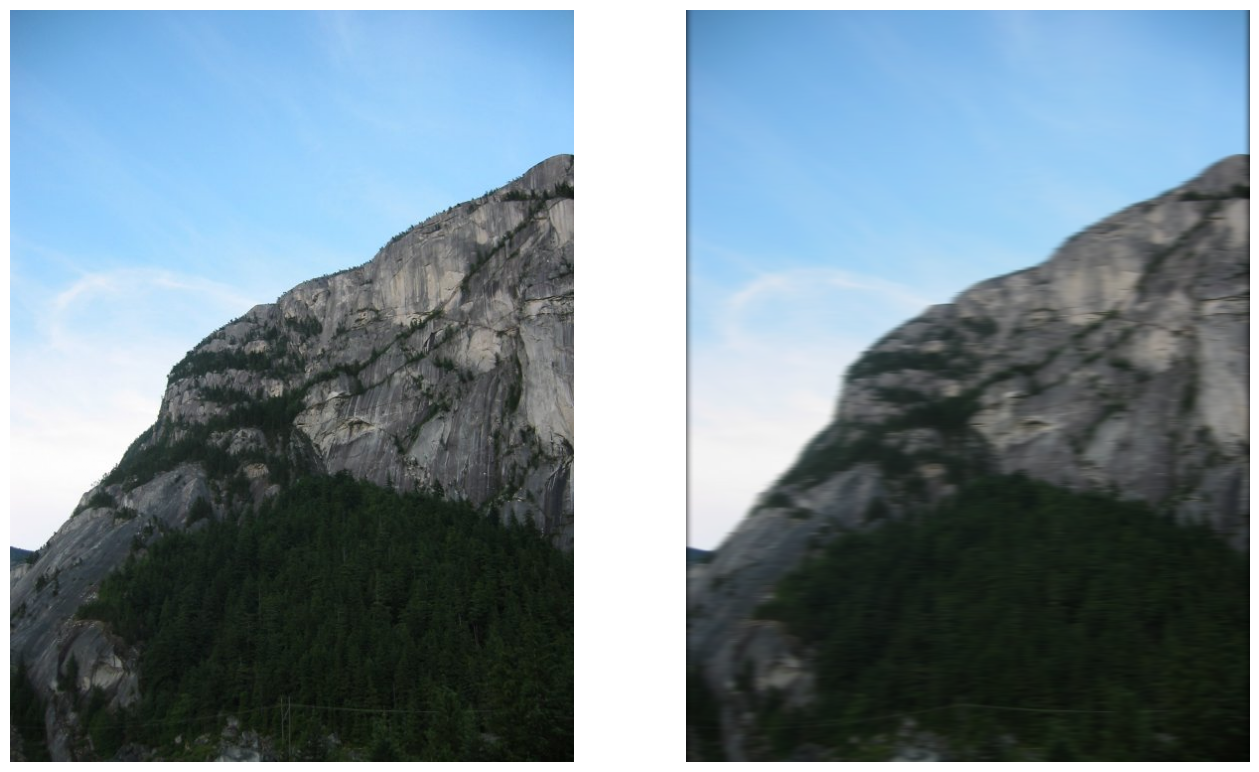

In [4]:
"""
Gaussian blurring test
"""
print('[ Test convolve_gaussian ]')

sigma=4.0
k=im_util.gauss_kernel(sigma)
print(' gauss kernel = ')
print(k)

t0=time()
im1 = im_util.convolve_gaussian(im, sigma)
t1=time()
print(' % .2f secs' % (t1-t0))

ax1,ax2=im_util.plot_two_images(im, im1)

Now write code to compute horizontal and vertical gradients in the function `compute_gradients`. Use an explicit kernel that is convolved in each direction (i.e., do not use a built-in function such as `numpy.gradient`). Run the code below and check that the outputs look sensible.

[ Test gradient computation ]


(<Axes: >, <Axes: >)

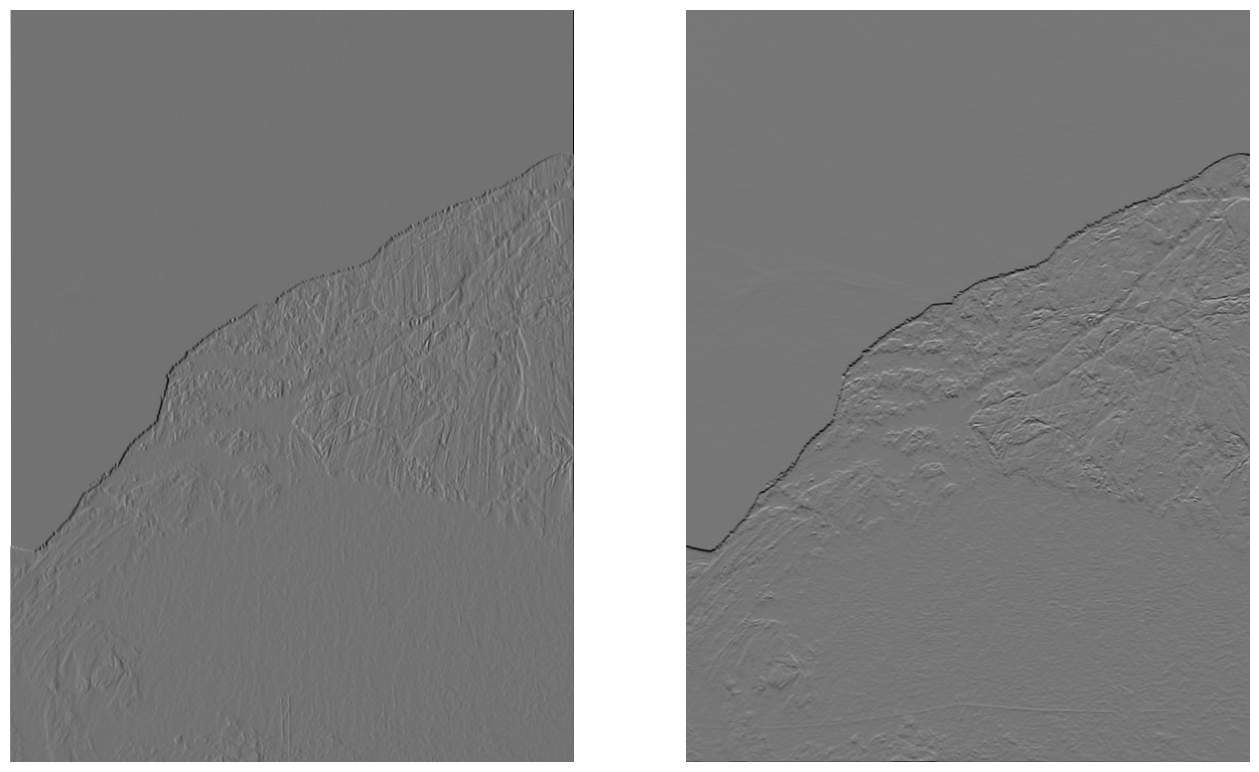

In [5]:
"""
Gradient computation test
"""
print('[ Test gradient computation ]')
img = np.mean(im,2,keepdims=True)
Ix,Iy = im_util.compute_gradients(img)

# copy greyvalue to RGB channels
Ix_out = im_util.grey_to_rgb(im_util.normalise_01(Ix))
Iy_out = im_util.grey_to_rgb(im_util.normalise_01(Iy))

im_util.plot_two_images(Ix_out, Iy_out)

### Interest Point Extractor

Now you will use these convolution functions to implement a corner or interest point detector. Choose a well known detector, such as Harris or DoG, and implement the interest point strength function in `corner_function` of `interest_point.py`. Run the code below to visualise your corner function output. Next detect corners as local maxima of this function by filling in `find_local_maxima` in the same file.

[ Compute corner strength ]
[ Find local maxima ]


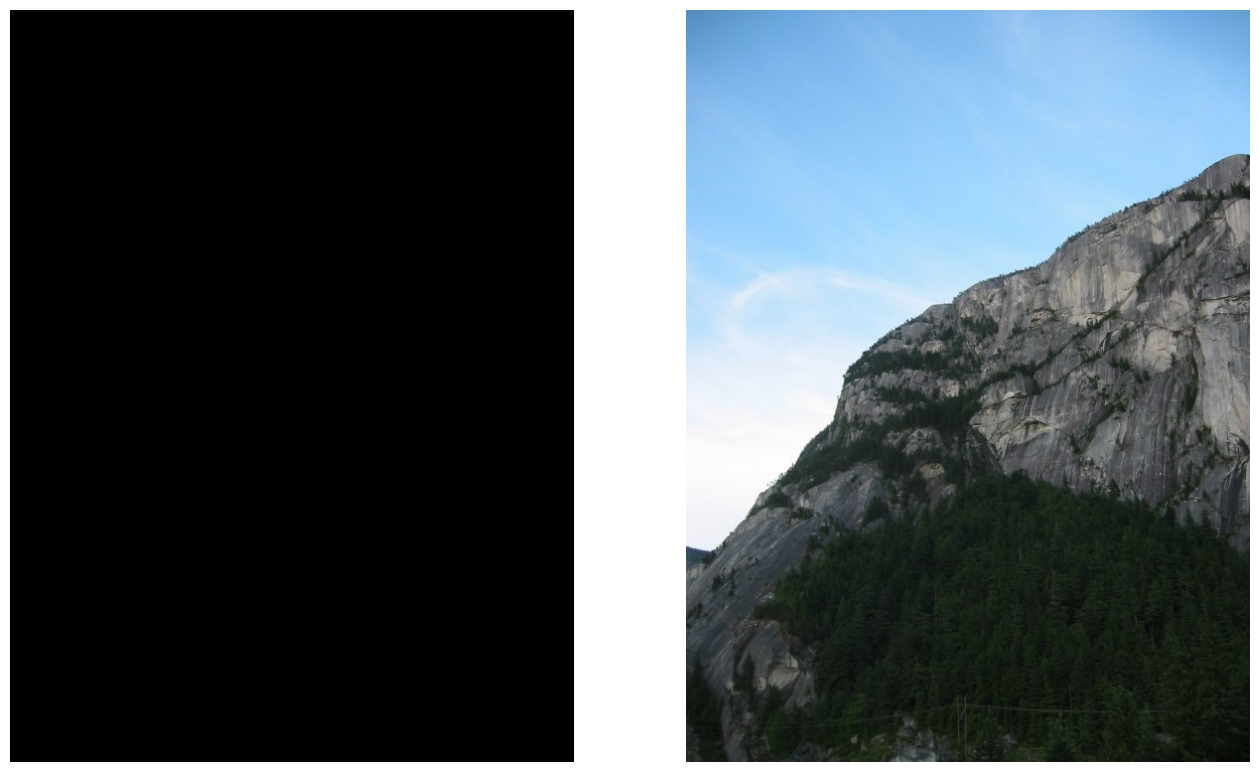

In [6]:
"""
Compute corner strength function
"""
print('[ Compute corner strength ]')
ip_ex = interest_point.InterestPointExtractor()
ip_fun = ip_ex.corner_function(img)

# normalise for display
[mn,mx]=np.percentile(ip_fun,[5,95])
small_val=1e-9
ip_fun_norm=(ip_fun-mn)/(mx-mn+small_val)
ip_fun_norm=np.maximum(np.minimum(ip_fun_norm,1.0),0.0)

"""
Find local maxima of corner strength
"""
print('[ Find local maxima ]')
row, col = ip_ex.find_local_maxima(ip_fun)
ip = np.stack((row,col))

ax1,ax2=im_util.plot_two_images(im_util.grey_to_rgb(ip_fun_norm),im)
interest_point.draw_interest_points_ax(ip, ax2)

In [7]:
ip_fun.shape

(758, 568, 1)

### Descriptors and Matching

Now let's match our interest points. Start by extracting a very simple descriptor that is simply a patch of pixels around the interest point. To do this, fill in the function `get_descriptors` in `interest_point.py`. The following code outputs a random set of normalised descriptor patches. Check that the output looks sensible. Once you have this working, try varying the sample spacing in your descriptor patch. "Sample spacing" here means distance in pixels in the base image between the pixels in your descriptor patch. What problem exists with sample spacings > 1 pixel? How can this be fixed?

[ Extract descriptors ]


ValueError: high <= 0

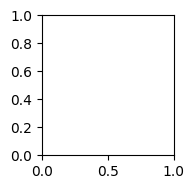

In [8]:
"""
Extract descriptors
"""
print('[ Extract descriptors ]')
desc_ex=interest_point.DescriptorExtractor()
descriptors=desc_ex.get_descriptors(img, ip)
interest_point.plot_descriptors(descriptors,plt)

We will now match descriptors between a pair of images. Run the following two code blocks to extract your interest points and extract and match descriptors. The second code block calls a function to perform nearest-neighbour matching of descriptors and filtering using a ratio test. Take a look at the code and check you understand how it works.

[ find interest points ]
 found 0 in image 1
 found 0 in image 2
  0.20 secs 
[ drawing interest points ]
  0.00 secs 


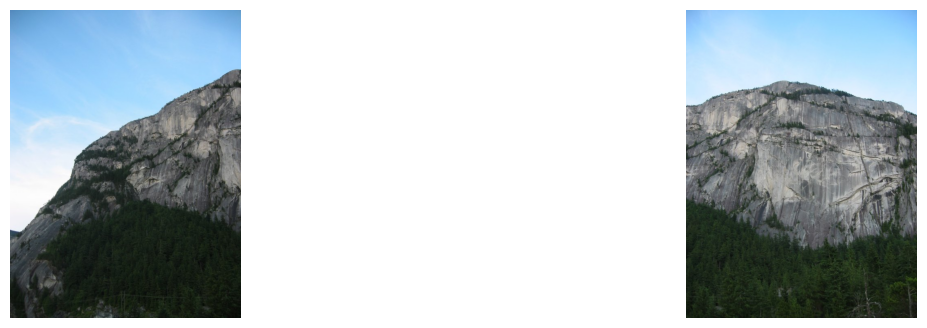

In [ ]:
"""
Read a pair of input images and extract interest points
"""
image_dir='data/test'
#im_filename1=image_dir+'/100-0023_img.jpg'
#im_filename2=image_dir+'/100-0024_img.jpg'
im_filename1=image_dir+'/100-0038_img.jpg'
im_filename2=image_dir+'/100-0039_img.jpg'

im1 = im_util.image_open(im_filename1)
im2 = im_util.image_open(im_filename2)

img1 = np.mean(im1, 2, keepdims=True)
img2 = np.mean(im2, 2, keepdims=True)

print('[ find interest points ]')
t0=time()
ip_ex = interest_point.InterestPointExtractor()
ip1 = ip_ex.find_interest_points(img1)
print(' found '+str(ip1.shape[1])+' in image 1')
ip2 = ip_ex.find_interest_points(img2)
print(' found '+str(ip2.shape[1])+' in image 2')
t1=time()
print(' % .2f secs ' % (t1-t0))

print('[ drawing interest points ]')
ax1,ax2=im_util.plot_two_images(im1,im2)
t0=time()
interest_point.draw_interest_points_ax(ip1, ax1)
interest_point.draw_interest_points_ax(ip2, ax2)
t1=time()
print(' % .2f secs ' % (t1-t0))

In [ ]:
"""
Extract and match descriptors
"""
print('[ extract descriptors ]')
t0=time()
desc_ex = interest_point.DescriptorExtractor()
desc1 = desc_ex.get_descriptors(img1, ip1)
desc2 = desc_ex.get_descriptors(img2, ip2)
t1=time()
print(' % .2f secs' % (t1-t0))

# Uncomment the following lines to use SIFT descriptors
# Note: you'll need to install cyvlfeat, e.g., conda install -c menpo cyvlfeat

#from cyvlfeat import sift
#frames1,desc1=sift.sift(img1,compute_descriptor=True,n_levels=1)
#frames2,desc2=sift.sift(img2,compute_descriptor=True,n_levels=1)
#ip1=(frames1.T)[0:2,:]
#ip2=(frames2.T)[0:2,:]
#desc1=desc1.astype(np.float)
#desc2=desc2.astype(np.float)

print('[ match descriptors ]')
match_idx,ratio_pass=desc_ex.match_ratio_test(desc1, desc2)
num_ratio_pass=np.sum(ratio_pass)

ipm=ip2[:,match_idx]

ip1r=ip1[:,ratio_pass]
ip2r=ipm[:,ratio_pass]

N1,num_dims=desc1.shape
print(' Number of interest points = '+str(N1))
print(' Number of matches passing ratio test = '+str(num_ratio_pass))

ax1,ax2=im_util.plot_two_images(im1,im2)
interest_point.draw_matches_ax(ip1r, ip2r, ax1, ax2)

[ extract descriptors ]
  0.00 secs
[ match descriptors ]


IndexError: index 0 is out of bounds for axis 1 with size 0

The following code visualises matched descriptor patches. Can you distinguish the correct and incorrect matches? (reload to get another random sample).

In [ ]:
"""
Plot descriptors for matched points
"""
interest_point.plot_matching_descriptors(desc1,desc2,np.arange(0,ip1.shape[1]),match_idx,plt)

NameError: name 'match_idx' is not defined